In [21]:
from datasets import load_from_disk
from pathlib import Path
import matplotlib.pyplot as plt

In [27]:
project_root = Path.cwd().parent
data_path_test = project_root / "data" / "test"
data_path_validation = project_root / "data" / "validation"
data_path_train = project_root / "data" / "validation"

dataset = load_from_disk(str(data_path_train))


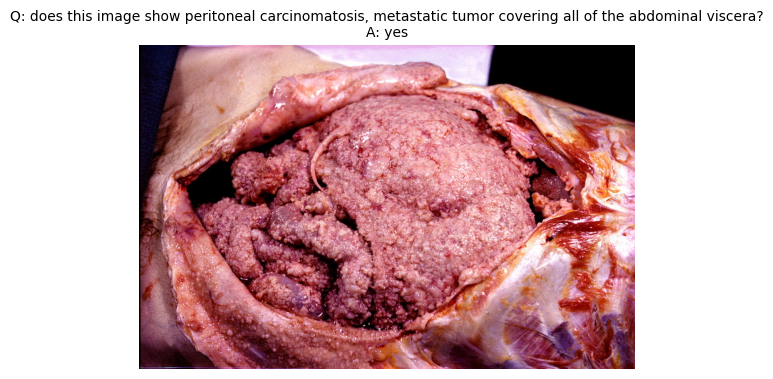

In [36]:
sample = dataset[9]  
image = sample["image"] 
question = sample["question"]
answer = sample["answer"]

plt.imshow(image)
plt.axis("off") 
plt.title(f"Q: {question}\nA: {answer}", fontsize=10)
plt.show()

In [4]:
from transformers import AutoTokenizer, AutoModel, CLIPProcessor, CLIPModel
import torch
import numpy as np

Bert initialisieren und Tokenizer für Text-Embeddings

In [6]:
model_name_text = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name_text)
text_model = AutoModel.from_pretrained(model_name_text)

C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\venv\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tekenisiert den Text und berechnet mit Mean-Pooling ein festes Embedding

In [7]:
def get_text_embedding(text):
    """
    Erzeugt ein Text-Embedding für einen gegebenen Text.
    Wir nutzen den BERT-Tokenizer und das Modell und führen Mean-Pooling
    über die letzten Hidden States durch.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = text_model(**inputs)
    # outputs.last_hidden_state hat die Form (batch_size, sequence_length, hidden_size)
    embeddings = outputs.last_hidden_state.squeeze(0)  # Batch-Dimension entfernen
    mean_embedding = embeddings.mean(dim=0).numpy()    # Mean-Pooling über alle Token
    return mean_embedding

clip laden

In [8]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\venv\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\venv\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Bild Embedding wird hier erzeugt, liefert einen Vektor der das Bild repräsentiert

In [9]:
def get_image_embedding(image):
    """
    Erzeugt ein Bild-Embedding mithilfe des CLIP-Modells.
    """
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_emb = clip_model.get_image_features(**inputs)
    # Entferne die Batch-Dimension und konvertiere zu numpy
    image_emb = image_emb.squeeze().numpy()
    return image_emb

Text Embedding und Bild Embedding kombinieren da wir Frage+Bild haben

In [10]:
def get_combined_embedding(sample):
    """
    Erzeugt einen kombinierten Feature-Vektor aus der Frage (Text) und dem Bild.
    Hier werden die beiden Embeddings durch Konkatenation zu einem langen Vektor zusammengeführt.
    """
    # Text-Embedding berechnen
    text_emb = get_text_embedding(sample["question"])
    # Bild-Embedding berechnen
    image_emb = get_image_embedding(sample["image"])
    # Kombiniere beide Vektoren
    combined_embedding = np.concatenate([text_emb, image_emb])
    return combined_embedding

Sequentielle Auswahl aud dem Paper SelfDis definieren

In [11]:
# Zelle 5: Definiere die sequenzielle Auswahl (SelfDis)

def sequential_selfdis_selection(dataset, M):
    """
    Wählt M Beispiele aus dem Datensatz aus, indem iterativ das Beispiel ausgewählt wird,
    das am dissimilarsten zu den bereits ausgewählten Beispielen ist (basierend auf der Cosinus-Similarität).
    """
    print("Extrahiere Embeddings für alle Beispiele...")
    embeddings = []
    for i, sample in enumerate(dataset):
        emb = get_combined_embedding(sample)
        embeddings.append(emb)
        if i % 100 == 0:
            print(f"{i} Beispiele verarbeitet...")
    embeddings = np.array(embeddings)
    
    # Initialisiere die Auswahl mit einem zufälligen Beispiel
    selected_indices = [np.random.choice(len(dataset))]
    
    # Iterative Auswahl: Solange weniger als M Beispiele ausgewählt wurden
    while len(selected_indices) < M:
        best_score = -np.inf
        best_idx = None
        
        # Gehe alle noch nicht ausgewählten Beispiele durch
        for i in range(len(dataset)):
            if i in selected_indices:
                continue
            sim_sum = 0.0
            # Berechne die Summe der Cosinus-Similaritäten zu allen bereits ausgewählten Beispielen
            for j in selected_indices:
                dot_product = np.dot(embeddings[i], embeddings[j])
                norm_product = np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j])
                cos_sim = dot_product / norm_product if norm_product != 0 else 0
                sim_sum += cos_sim
            # Score als negativer Summenwert (höher = dissimilarer)
            score = -sim_sum
            if score > best_score:
                best_score = score
                best_idx = i
        selected_indices.append(best_idx)
        print(f"Beispiel {best_idx} wurde hinzugefügt. (Auswahlgröße: {len(selected_indices)}/{M})")
    
    return selected_indices


Anwendung der Beiden Funktionen 

In [12]:
# Anzahl der gewünschten Beispiele (z. B. 10)
M = 10

print("Starte die sequenzielle Auswahl...")
selected_indices = sequential_selfdis_selection(dataset, M)


Starte die sequenzielle Auswahl...
Extrahiere Embeddings für alle Beispiele...
0 Beispiele verarbeitet...
100 Beispiele verarbeitet...
200 Beispiele verarbeitet...
300 Beispiele verarbeitet...
400 Beispiele verarbeitet...
500 Beispiele verarbeitet...
600 Beispiele verarbeitet...
700 Beispiele verarbeitet...
800 Beispiele verarbeitet...
900 Beispiele verarbeitet...
1000 Beispiele verarbeitet...
1100 Beispiele verarbeitet...
1200 Beispiele verarbeitet...
1300 Beispiele verarbeitet...
1400 Beispiele verarbeitet...
1500 Beispiele verarbeitet...
1600 Beispiele verarbeitet...
1700 Beispiele verarbeitet...
1800 Beispiele verarbeitet...
1900 Beispiele verarbeitet...
2000 Beispiele verarbeitet...
2100 Beispiele verarbeitet...
2200 Beispiele verarbeitet...
2300 Beispiele verarbeitet...
2400 Beispiele verarbeitet...
2500 Beispiele verarbeitet...
2600 Beispiele verarbeitet...
2700 Beispiele verarbeitet...
2800 Beispiele verarbeitet...
2900 Beispiele verarbeitet...
3000 Beispiele verarbeitet...
310

C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


13500 Beispiele verarbeitet...
13600 Beispiele verarbeitet...
13700 Beispiele verarbeitet...
13800 Beispiele verarbeitet...
13900 Beispiele verarbeitet...
14000 Beispiele verarbeitet...
14100 Beispiele verarbeitet...
14200 Beispiele verarbeitet...
14300 Beispiele verarbeitet...
14400 Beispiele verarbeitet...
14500 Beispiele verarbeitet...
14600 Beispiele verarbeitet...
14700 Beispiele verarbeitet...
14800 Beispiele verarbeitet...
14900 Beispiele verarbeitet...
15000 Beispiele verarbeitet...
15100 Beispiele verarbeitet...
15200 Beispiele verarbeitet...
15300 Beispiele verarbeitet...
15400 Beispiele verarbeitet...
15500 Beispiele verarbeitet...
15600 Beispiele verarbeitet...
15700 Beispiele verarbeitet...
15800 Beispiele verarbeitet...
15900 Beispiele verarbeitet...
16000 Beispiele verarbeitet...
16100 Beispiele verarbeitet...
16200 Beispiele verarbeitet...
16300 Beispiele verarbeitet...
16400 Beispiele verarbeitet...
16500 Beispiele verarbeitet...
16600 Beispiele verarbeitet...
16700 Be

Beispiele anzeigen um visuell zu überprüfen

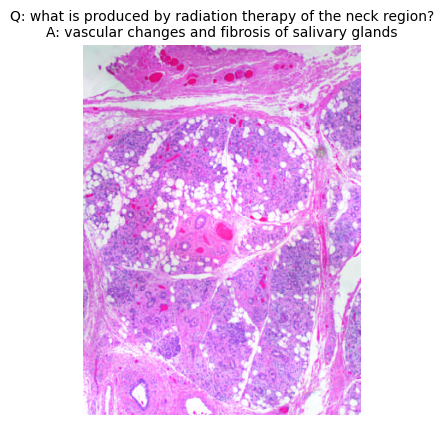

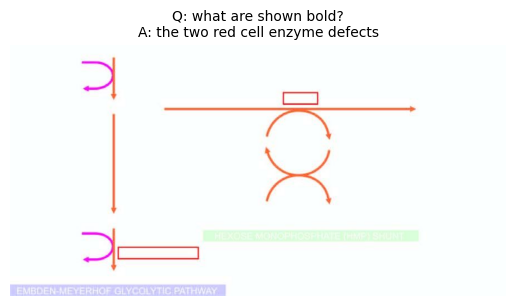

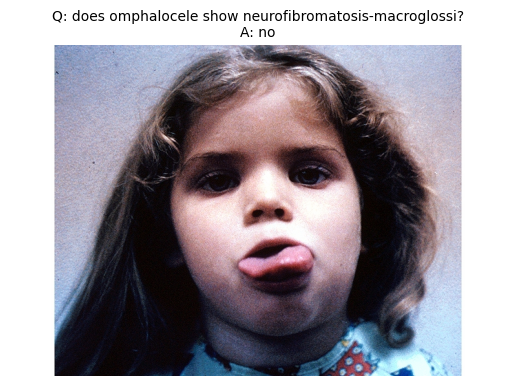

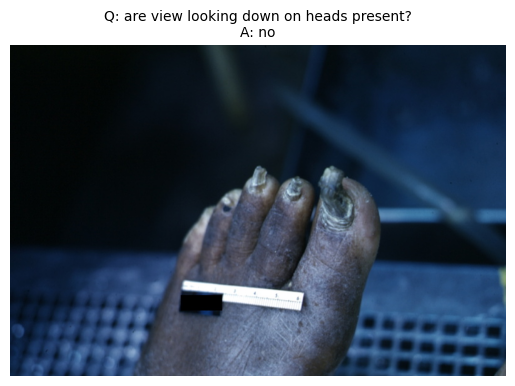

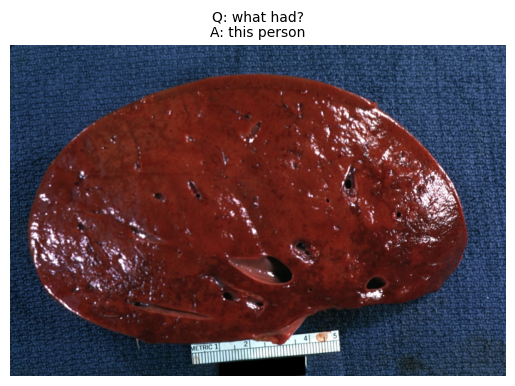

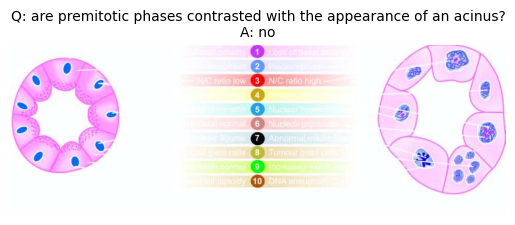

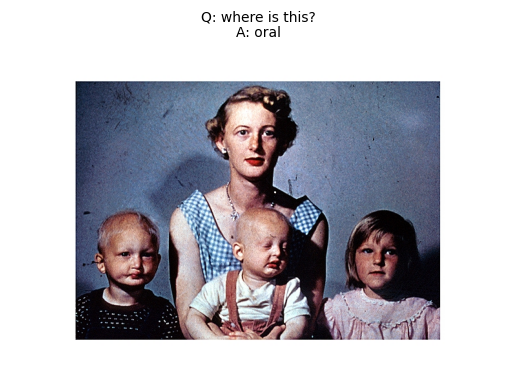

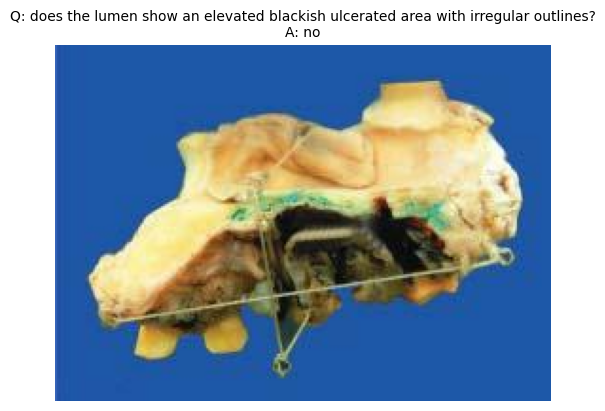

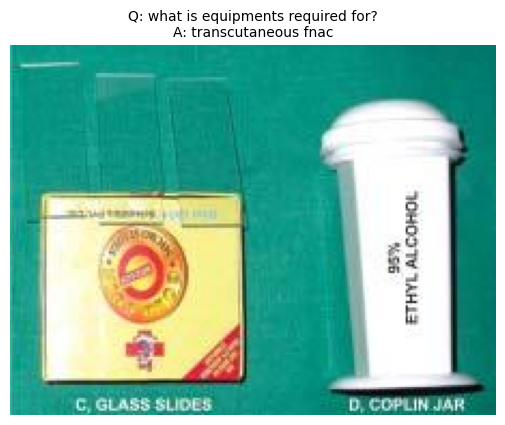

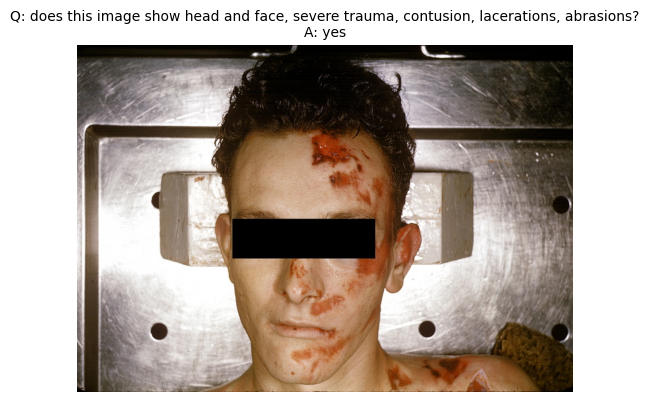

In [13]:
for idx in selected_indices:
    sample = dataset[idx]
    image = sample["image"]
    question = sample["question"]
    answer = sample["answer"]
    
    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Q: {question}\nA: {answer}", fontsize=10)
    plt.show()

In [14]:
print(selected_indices)

[12378, 10691, 9476, 16782, 1412, 9469, 7863, 12009, 10225, 12698]


Wir nutzen jetzt noch die Verteilung der Fragetypen um von jeder Frage ein repräsentatives Beispiel zu haben

Starte die repräsentative Auswahl pro Fragetyp...


C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor